In [1]:
import pandas as pd
from scipy.signal import correlate, fftconvolve
import numpy as np
from scipy.io import wavfile
from altair import *

%matplotlib inline
import logging
logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

## Audio Processing

Function for destructively shifting a signal (`sig2`) so it is aligned with another signal (`sig1`), using the cross-correlation.

In [2]:
def shift_signal(sig1, sig2, plot=False):
    # Get cross-correlation
    xc = fftconvolve(sig1, sig2[::-1], mode='full')
    if plot:
        plt.figure()
        xaxis=np.arange(-len(sig1)+1,len(sig2))
        plt.plot(xaxis, xc)
        plt.show()
    # How far in to shift sig2
    offset = -1*int(np.argmax(xc)-sig2.size)
    shifted2=sig2.copy()
    # Shift signal start
    if offset >= 0:
        logger.info("Truncate head...{}".format(offset))
        shifted2 = sig2[offset:]
    else:
        logger.info("Pad head...{}".format(offset))
        shifted2 = np.concatenate((np.zeros(-offset, dtype=sig2.dtype), sig2))
    # Deal with signal tail
    if shifted2.size >= sig1.size:
        shifted2 = shifted2[:sig1.size]
    else:
        padding = np.zeros(sig1.size-shifted2.size, dtype=shifted2.dtype)
        shifted2 = np.concatenate((shifted2, padding))

    assert sig1.size==shifted2.size
    return shifted2

Align wav files collected from different devices:

In [3]:
fs=['audio/xp1/abhi_iphone_44100.wav',
 'audio/xp1/pats_android_44100.wav',
 'audio/xp1/pats_computer2_44100.wav',
 'audio/xp1/pats_computer_44100.wav',
 'audio/xp1/pats_iphone_44100.wav']

# Load wav data
wav_data = [wavfile.read(x) for x in fs]
sample_rate = wav_data[0][0]
assert all([x[0]==sample_rate for x in wav_data]), "Sample rates don't match"
# remove sample rates from data
wav_data = [x[1] for x in wav_data]
# shift everything re: first record
shifted = np.concatenate([wav_data[0][:, None]] + [shift_signal(wav_data[0], x)[:,None] for x in wav_data[1:]],  axis=1)

INFO:__main__:Truncate head...5000
INFO:__main__:Pad head...-85587
INFO:__main__:Pad head...-85587
INFO:__main__:Pad head...-32195


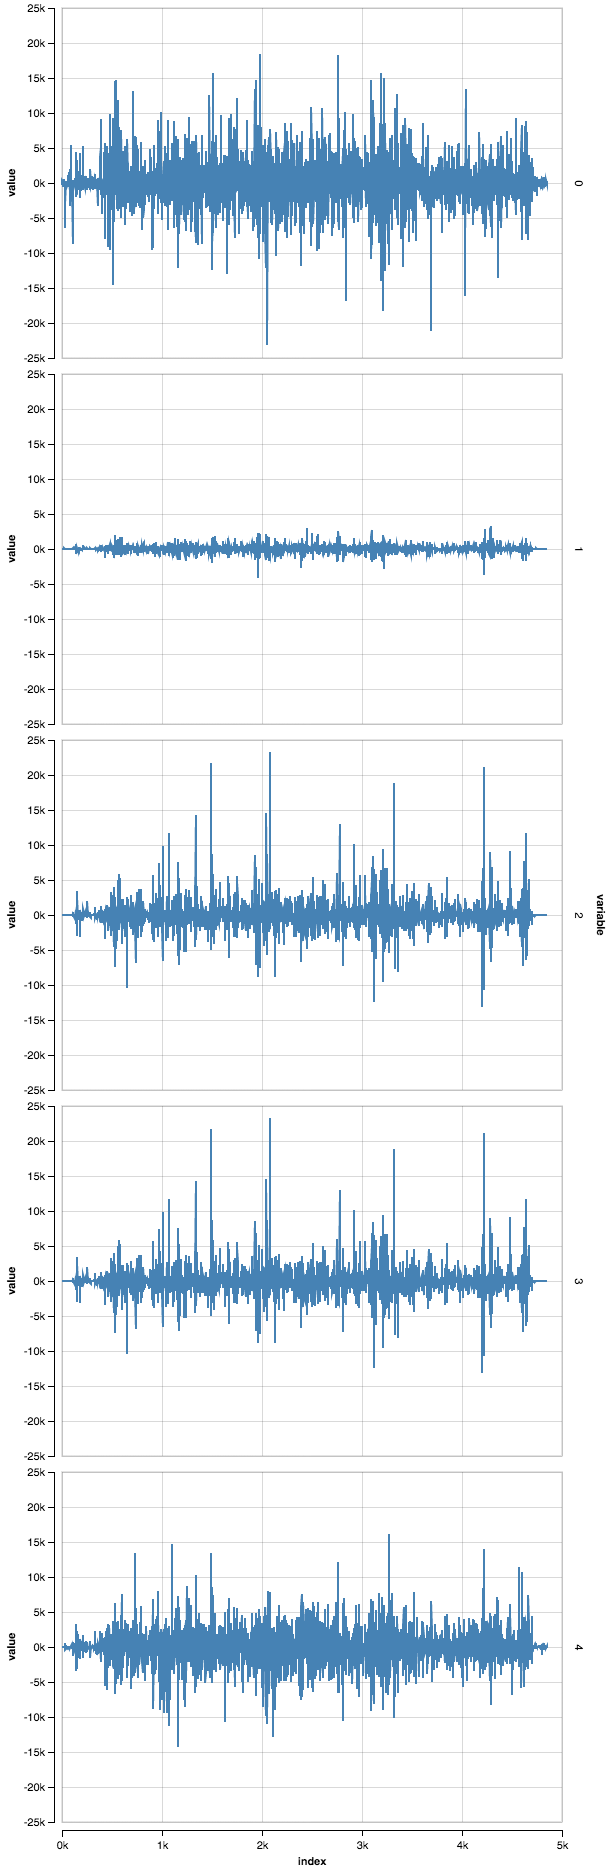

In [4]:
def plot_audio(sig):
    sig_df = pd.DataFrame.from_records(sig)
    sig_long = pd.melt(sig_df.reset_index(), id_vars=('index',))
    sig_chart = (Chart(sig_long)
                 .mark_line()
                 .encode(x='index',
                         y='value',
                         row='variable:O'))
    return sig_chart
plot_audio(shifted[::1000, :])
#shifted_df = pd.DataFrame.from_records(shifted[:,:])
#shifted_long = pd.melt(shifted_df.reset_index(), id_vars=('index',))

## Do ICA

In [5]:
from sklearn.decomposition import FastICA
fica = FastICA(3)
new_audio = fica.fit_transform(shifted[441000:882000,:])

/Users/patrickc/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Save it off:

In [6]:
wavfile.write("ica_garden.wav",sample_rate,new_audio)

Plot a 10-second sample:

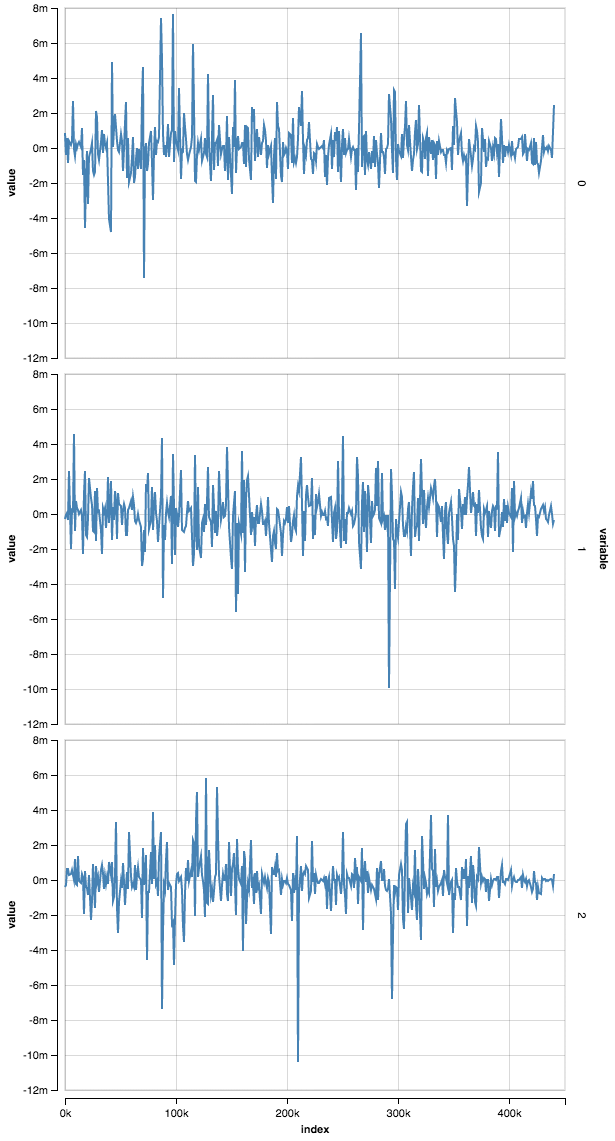

In [7]:
new_audio_df = pd.DataFrame.from_records(new_audio[:,:])
new_audio_long = pd.melt(new_audio_df.reset_index(), id_vars=('index',))
(Chart(new_audio_long.iloc[[t % 1000 == 0 for t in range(len(new_audio_long))], :])
 .mark_line()
 .encode(x='index',
         y='value',
         row='variable:O')
 )